# ch07 畳み込みニューラルネットワーク
## 7.4 Convolution / Poolingレイヤの実装

In [1]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from common.util import im2col

x1 = np.random.randn(1, 3, 7, 7)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape)

x2 = np.random.randn(10, 3, 7, 7)
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)

(9, 75)
(90, 75)


In [2]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T
        out = np.dot(col, col_W) + self.b

        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        return out

In [3]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        H, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        return out

In [14]:
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient

class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param={'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 重みパラメータの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * \
            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers["Relu1"] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db

        return grads

train loss:2.299904279009841
=== epoch:1, train acc:0.108, test acc:0.128 ===
train loss:2.296274360818689
train loss:2.2943341872593304
train loss:2.289614078606289
train loss:2.2819902037961977
train loss:2.2696401099976327
train loss:2.2694271762874205
train loss:2.222588407641203
train loss:2.2333640526828855
train loss:2.2311699386057815
train loss:2.172605136514345
train loss:2.156617268350098
train loss:2.1245845049275527
train loss:2.0918051546378584
train loss:2.0298469064390643
train loss:1.9662735801183364
train loss:1.95688548225358
train loss:1.9022357820974898
train loss:1.7667263433557334
train loss:1.7193544237230285
train loss:1.6079236274503368
train loss:1.4789725720062645
train loss:1.4291612213527054
train loss:1.47293339372815
train loss:1.2554466459378097
train loss:1.2029299563063862
train loss:1.166414683248653
train loss:1.118884779398399
train loss:0.9527870016398148
train loss:1.0893918795937623
train loss:1.0302552593786565
train loss:0.9240829641627343
tra

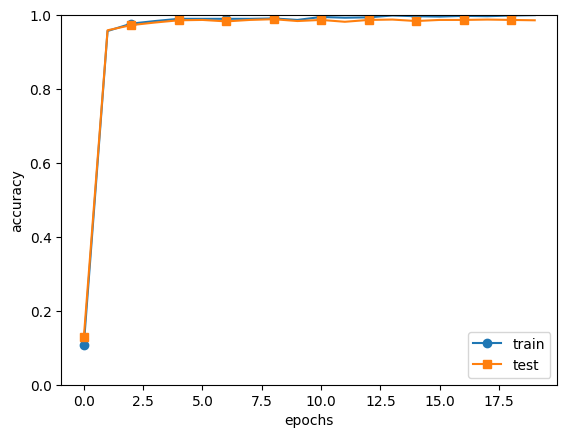

In [16]:
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.trainer import Trainer

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1, 28, 28),
                        conv_param={
                            'filter_num': 30,
                            'filter_size': 5,
                            'pad': 0,
                            'stride': 1
                        },
                        hidden_size=100,
                        output_size=10,
                        weight_init_std=0.01)

trainer = Trainer(network,
                  x_train,
                  t_train,
                  x_test,
                  t_test,
                  epochs=max_epochs,
                  mini_batch_size=100,
                  optimizer='Adam',
                  optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()